In [1]:
import numpy as np
import pandas as pd
import csv
import string

In [2]:
#data frame download
import re
file_path = 'shot_logs.csv'
dtype_dict ={'GAME_ID': int, 'MATCHUP': str, 'LOCATION': str, 'W': str, 'FINAL_MARGIN': int, 
                         'SHOT_NUMBER': int, 'PERIOD': int, 'GAME_CLOCK': str, 'SHOT_CLOCK': str, 
                         'DRIBBLES': int, 'TOUCH_TIME': float, 'SHOT_DIST': float, 'PTS_TYPE': int, 
                         'SHOT_RESULT': str, 'CLOSEST_DEFENDER': str, 'CLOSEST_DEFENDER_PLAYER_ID': int, 
                         'CLOSE_DEF_DIST': float, 'FGM': int, 'PTS': int, 'player_name': str, 'player_id': int}
df = pd.read_csv(file_path, sep=",", dtype=dtype_dict)

In [3]:
#data cleanse
df['SHOT_RESULT'] = df['SHOT_RESULT'].map({'made': 1, 'missed' : 0})
def split_date_and_matchup(date_str):
    # Extract the date part using regex
    date_match = re.search(r'\b\w{3} \d{2}, \d{4}\b', date_str)
    if date_match:
        # Extract date and convert to YYYY-MM-DD format
        date = pd.to_datetime(date_match.group(0), format='%b %d, %Y').strftime('%Y-%m-%d')
        # Extract matchup string by removing the date part and the separator
        matchup = date_str.replace(date_match.group(0) + ' - ', '')
        return pd.Series([date, matchup])
    else:
        return pd.Series([None, None])
df[['DATE', 'MATCHUP']] = df['MATCHUP'].apply(split_date_and_matchup)
df.head()
df.loc[df['TOUCH_TIME'] < 0, 'TOUCH_TIME'] = np.nan
df = df.dropna()


In [44]:
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,DATE
0,21400899,CHA @ BKN,A,W,24,1,1,1:09,10.8,2,...,2,1,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,2015-03-04
1,21400899,CHA @ BKN,A,W,24,2,1,0:14,3.4,0,...,3,0,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,2015-03-04
3,21400899,CHA @ BKN,A,W,24,4,2,11:47,10.3,2,...,2,0,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,2015-03-04
4,21400899,CHA @ BKN,A,W,24,5,2,10:34,10.9,2,...,2,0,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,2015-03-04
5,21400899,CHA @ BKN,A,W,24,6,2,8:15,9.1,2,...,2,0,"Williams, Deron",101114,2.6,0,0,brian roberts,203148,2015-03-04


In [16]:
#input player name
p_first = input("Enter the player's first name: (ex. 'james')")
p_last = input("Enter the player's last name: (ex. 'harden)")
#remove any accidental white spaces, making it uniform
p_first = p_first.strip().lower()
p_last = p_last.strip().lower()
player_name = p_first + " " + p_last
#keep requesting input until correct
if not(player_name in df['player_name'].values):
    print("Error: Name could not be found. Player will be defaulted to stephen curry")
    player_name = 'stephen curry'

#create df of just that player
player_df = df[df['player_name'] == player_name]

#total shooting percentage
tot_shots = len(player_df)
made_shots = (player_df['SHOT_RESULT'] == 1).sum()
tot_shot_pct = made_shots / tot_shots

#print(player_df.head())
#2 pt shooting_percentage
tot_2pt_shots = (player_df['PTS_TYPE'] == 2).sum()
made_2pt_shots = ((player_df['SHOT_RESULT'] == 1) & (player_df['PTS_TYPE'] == 2)).sum()
tot_2pt_shot_pct = made_2pt_shots / tot_2pt_shots

#3 pt shooting_percentage
tot_3pt_shots = (player_df['PTS_TYPE'] == 3).sum()
made_3pt_shots = ((player_df['SHOT_RESULT'] == 1) & (player_df['PTS_TYPE'] == 3)).sum()
tot_3pt_shot_pct = made_3pt_shots / tot_3pt_shots

#Best Matchup
defenders = player_df['CLOSEST_DEFENDER'].tolist()
defender_pct = {}
for defender in defenders:
    tot_per_def = (player_df['CLOSEST_DEFENDER'] == defender).sum()
    if (tot_per_def >= 10):
        made_per_def = ((player_df['CLOSEST_DEFENDER'] == defender) & (player_df['SHOT_RESULT'] == 1)).sum()
        defender_pct[defender] = made_per_def / tot_per_def
best_matchup = max(defender_pct, key=lambda k: defender_pct[k])
best_matchup_pct = defender_pct[best_matchup]

#Worst Matchup
worst_matchup = min(defender_pct, key=lambda k: defender_pct[k])
worst_matchup_pct = defender_pct[worst_matchup]

#wide open based off 2k
wide_open_df =  player_df[player_df['CLOSE_DEF_DIST'] >=  4]
wide_open_makes = (wide_open_df['SHOT_RESULT'] == 1).sum()
tot_wide_open = len(wide_open_df)
wide_open_pct = wide_open_makes / tot_wide_open

#open/contested
open_df =  player_df[player_df['CLOSE_DEF_DIST'] <  4]
open_makes = (open_df['SHOT_RESULT'] ==  1).sum()
tot_open = len(open_df)
open_pct = open_makes / tot_open

#print statements
print(string.capwords(player_name, sep=None))
print('Shooting Percentage: ', tot_shot_pct)
print('2pt Shooting Percentage: ', tot_2pt_shot_pct)
print('3pt Shooting Percentage: ', tot_3pt_shot_pct)
print('Best Matchup: ', best_matchup, ': ', best_matchup_pct)
print('Worst Matchup: ', worst_matchup, ': ', worst_matchup_pct)
print('Wide Open Percentage: ', wide_open_pct)
print('Open/Contested Percentage: ', open_pct)







james harden
James Harden
Shooting Percentage:  0.4487562189054726
2pt Shooting Percentage:  0.4943639291465378
3pt Shooting Percentage:  0.375
Best Matchup:  Green, Danny :  0.7272727272727273
Worst Matchup:  Redick, JJ :  0.2727272727272727
Wide Open Percentage:  0.44418052256532065
Open/Contested Percentage:  0.4520547945205479


In [17]:
#K-Cluster
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#features_to_scale = ['SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME', ]
#scaler = StandardScaler()
#df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
player_df_clustering = player_df[['SHOT_DIST', 'CLOSE_DEF_DIST']]
player_df.describe()


,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.005000e+03,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.00000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.0
mean,2.140045e+07,3.459701,9.992040,2.431841,4.836816,5.651741,14.812338,2.38209,0.448756,168852.259701,3.784677,0.448756,1.040796,201935.0
std,2.550326e+02,12.083855,6.237652,1.110696,5.283896,4.568137,9.353827,0.48614,0.497615,71496.086396,2.131523,0.497615,1.195663,0.0
min,2.140000e+07,-28.000000,1.000000,1.000000,0.000000,0.000000,0.200000,2.00000,0.000000,977.000000,0.000000,0.000000,0.000000,201935.0
25%,2.140024e+07,-7.000000,5.000000,1.000000,1.000000,2.000000,4.600000,2.00000,0.000000,200782.000000,2.500000,0.000000,0.000000,201935.0
50%,2.140046e+07,5.000000,9.000000,3.000000,3.000000,4.700000,16.600000,2.00000,0.000000,202323.000000,3.500000,0.000000,0.000000,201935.0
75%,2.140067e+07,12.000000,14.000000,3.000000,7.000000,7.700000,24.400000,3.00000,1.000000,203086.000000,4.700000,1.000000,2.000000,201935.0
max,2.140090e+07,36.000000,32.000000,5.000000,30.000000,23.400000,33.900000,3.00000,1.000000,204060.000000,17.000000,1.000000,3.000000,201935.0


/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.

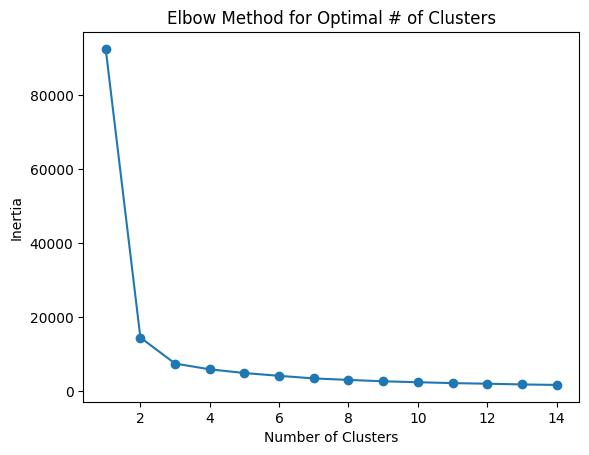

In [18]:
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(player_df_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 15), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal # of Clusters')
plt.show()

/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/jp/h32thjnj7g9741ybp3j739th0000gn/T/ipykernel_71564/809559726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['cluster'] = means.fit_predict(player_df_clustering)


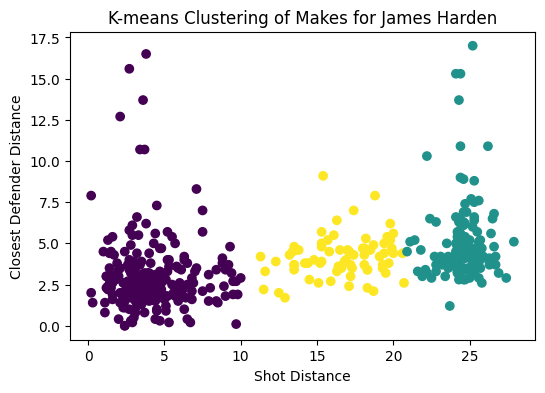

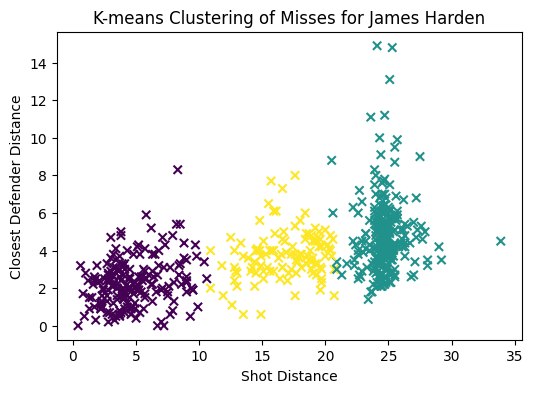

In [21]:
#EDIT NUM OF CLUSTERS DEPENDING ON GRAPH ABOVE
means = KMeans(n_clusters=3, random_state=0)
player_df['cluster'] = means.fit_predict(player_df_clustering)

makes = player_df[player_df['SHOT_RESULT'] == 1]
misses = player_df[player_df['SHOT_RESULT'] == 0]

# Plotting for makes
plt.figure(figsize=(6, 4))
plt.scatter(makes['SHOT_DIST'], makes['CLOSE_DEF_DIST'], c=makes['cluster'], cmap='viridis')
plt.xlabel('Shot Distance')
plt.ylabel('Closest Defender Distance')
plt.title('K-means Clustering of Makes for ' + string.capwords(player_name, sep=None))
plt.show()

# Plotting for misses
plt.figure(figsize=(6, 4))
plt.scatter(misses['SHOT_DIST'], misses['CLOSE_DEF_DIST'], c=misses['cluster'], marker='x', cmap='viridis')
plt.xlabel('Shot Distance')
plt.ylabel('Closest Defender Distance')
plt.title('K-means Clustering of Misses for ' + string.capwords(player_name, sep=None))
plt.show()

In [4]:
# Defender analysis
# Machine learning model to determine whether it can accurately decide whether a player will make a shot or not depending on the defender and proximity (contested shot within 5 ft)
# features: pts_type, closest_defender, closest_defender_distnace, shot_type
# output: shot_result

# isolate the defender based off user input (every shot where the closest defender is one person)
# determine a proper distance for what a contested shot is (5 ft)
# separate shots between close range, mid range, and 3 point
# eliminate any shot that is beyond half court (47 feet)

# fix the df so the name input doesn't have to be last name, first name

d_first = input("Please enter the defender's first name")
d_last = input("Please enter the defender's last name")
d_first = d_first.strip().lower().capitalize()
d_last = d_last.strip().lower().capitalize()
d_name = d_last + ", " + d_first


In [5]:
#get the defender's df where the only defender shown is the one input, and where the defender actually can affect the shot
defender_df = df[df['CLOSEST_DEFENDER'] == d_name]
defender_df = defender_df[defender_df['CLOSE_DEF_DIST'] <= 4]
#defender_df.head()

#separate into paint, close range, midrange, 3pt

defender_df_paint = defender_df[defender_df['SHOT_DIST'] <= 8]
defender_df_paint = defender_df[defender_df['CLOSE_DEF_DIST'] <= 2]
defender_df_cr = defender_df[defender_df['SHOT_DIST'].between(8, 16)]
defender_df_mr = defender_df[defender_df['SHOT_DIST'].between(16, 24)]
defender_df_mr = defender_df_mr[defender_df_mr['PTS_TYPE'] == 2]
defender_df_3pt = defender_df[defender_df['PTS_TYPE'] == 3]

defender_df_3pt.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,DATE
12000,21400003,LAL vs. HOU,H,L,-18,2,2,5:33,9.4,0,...,3,0,"Harden, James",201935,3.4,0,0,wesley johnson,202325,2014-10-28
13074,21400169,LAL @ HOU,A,W,6,7,3,3:48,5.7,4,...,3,1,"Harden, James",201935,3.6,1,3,nick young,201156,2014-11-19
13081,21400169,LAL @ HOU,A,W,6,14,4,4:07,8.5,4,...,3,0,"Harden, James",201935,3.5,0,0,nick young,201156,2014-11-19
14398,21400603,GSW @ HOU,A,W,25,4,1,3:56,21.9,0,...,3,0,"Harden, James",201935,3.8,0,0,stephen curry,201939,2015-01-17
15663,21400324,GSW vs. HOU,H,W,12,2,1,7:30,13.5,0,...,3,0,"Harden, James",201935,3.4,0,0,klay thompson,202691,2014-12-10


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

feature_cols = ['SHOT_DIST', 'CLOSE_DEF_DIST']
X = defender_df[feature_cols]
y = defender_df.SHOT_RESULT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.5135135135135135


In [15]:
#random tree classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [16]:
feature_cols = ['SHOT_DIST', 'CLOSE_DEF_DIST']
X = defender_df[feature_cols]
y = defender_df.SHOT_RESULT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.6271186440677966


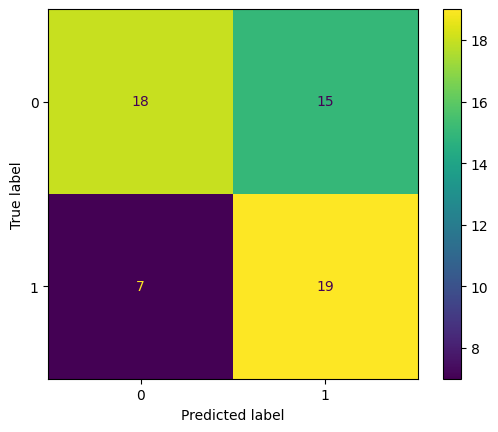

In [17]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()